In [ ]:
from datetime import datetime
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier, CatBoostRegressor

from lightgbm import LGBMClassifier
from sklearn.metrics import (
    accuracy_score,
    mean_squared_error,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split

# EDA & Leaks in Kaggle competitions and beyond

## Example: DSG 2016 finals

https://miptstream.ru/2016/09/12/mipt-wins-dsg2016/

![image.png](attachment:image.png)

По всей видимости, данные из разных классов собирались разными скриптами, и колонка с датой имела разный формат для разных классов, например:
- '2015-10-01' для класса 0
- '2015/10/01' для класса 1

Организаторы быстро поправили этот лик и перевыложили датасет. Очевидно, что использовать лик "в лоб" в этой ситуации нельзя.

Какой есть способ им все-таки воспользоваться?

## EDA: Walmart Trip Type classification

https://www.kaggle.com/c/walmart-recruiting-trip-type-classification

In [ ]:
train = pd.read_csv("../data/walmart/train.csv")
test = pd.read_csv("../data/walmart/test.csv")

In [ ]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


In [ ]:
test.head()

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,1,Friday,7.250339e+10,1,SHOES,3002.0
1,1,Friday,1.707711e+09,1,DAIRY,1526.0
2,1,Friday,8.947000e+10,1,DAIRY,1431.0
3,1,Friday,8.849121e+10,1,GROCERY DRY GOODS,3555.0
4,2,Friday,2.840015e+09,1,DSD GROCERY,4408.0


train and test looks the same

In [ ]:
train.groupby("VisitNumber")["TripType"].nunique().max()

1

In [ ]:
train["TripType"].nunique()

38

In [ ]:
sample_submisson = pd.read_csv("../data/walmart/sample_submission.csv")
sample_submisson.head()

,VisitNumber,TripType_3,TripType_4,TripType_5,TripType_6,TripType_7,TripType_8,TripType_9,TripType_12,TripType_14,...,TripType_36,TripType_37,TripType_38,TripType_39,TripType_40,TripType_41,TripType_42,TripType_43,TripType_44,TripType_999
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


for every `VisitNumber` u should predict proba for every possible `TripType`

how to do that? how to be with local validation?

In [ ]:
train_full = train.copy()

`train, oos = train_test_split(train_full, test_size=0.2, random_state=42)` ??

In [ ]:
train_full_visit_numbers = train_full["VisitNumber"].unique()
train_visit_numbers, oos_visit_numbers = train_test_split(
    train_full_visit_numbers, test_size=0.2, random_state=42
)

train = train_full[train_full["VisitNumber"].isin(train_visit_numbers)].copy()
oos = train_full[train_full["VisitNumber"].isin(oos_visit_numbers)].copy()

how to fit model? how to do predictions?

In [ ]:
target_col = "TripType"
possible_features = [
    "Weekday",
    "Upc",
    "ScanCount",
    "DepartmentDescription",
    "FinelineNumber",
]

In [ ]:
train[possible_features].nunique() / train.shape[0]

Weekday                  0.000014
Upc                      0.172272
ScanCount                0.000071
DepartmentDescription    0.000131
FinelineNumber           0.009905
dtype: float64

In [ ]:
cat_features = ["Weekday", "FinelineNumber", "DepartmentDescription", "ScanCount"]

In [ ]:
ctb = CatBoostClassifier(
    iterations=20,
    verbose=0,
    thread_count=1,
    allow_writing_files=False,
    cat_features=cat_features,
)

In [ ]:
train[cat_features] = train[cat_features].astype(str)
oos[cat_features] = oos[cat_features].astype(str)

In [ ]:
train_subs = train.sample(frac=0.1).copy()

In [ ]:
ctb.fit(train_subs[possible_features], train_subs[target_col])

In [ ]:
prediction_columns = [f"{target_col}_{i}" for i in ctb.classes_]
oos_preds_df = pd.DataFrame(
    ctb.predict_proba(oos[possible_features]), columns=prediction_columns
)
oos_preds_df["VisitNumber"] = oos["VisitNumber"].values

how to aggregate predictions for every `VisitNumber`?

In [ ]:
oos_targets = oos[["VisitNumber", target_col]].groupby("VisitNumber").min()

In [ ]:
oos_preds_df = oos_preds_df.groupby("VisitNumber").mean()
oos_preds_df = oos_preds_df.merge(
    oos_targets, left_index=True, right_index=True
).reset_index()

In [ ]:
oos_preds_df.head()

,VisitNumber,TripType_3,TripType_4,TripType_5,TripType_6,TripType_7,TripType_8,TripType_9,TripType_12,TripType_14,...,TripType_37,TripType_38,TripType_39,TripType_40,TripType_41,TripType_42,TripType_43,TripType_44,TripType_999,TripType
0,17,2.694466e-03,2.421167e-03,1.897418e-02,2.440420e-02,2.175164e-03,2.131507e-02,1.355848e-02,7.461840e-04,1.015788e-04,...,5.093550e-03,1.233467e-02,5.932711e-01,1.314727e-01,3.150253e-03,1.788436e-02,1.108336e-02,1.184069e-02,3.737897e-03,6
1,74,3.353460e-79,6.300698e-79,1.060074e-239,3.365430e-57,3.935244e-129,1.000000e+00,4.411277e-64,1.081198e-64,7.314124e-85,...,1.729200e-46,3.071649e-13,1.194254e-49,2.564889e-80,6.159153e-58,2.248349e-83,3.439784e-66,1.383931e-55,1.474745e-215,8
2,98,1.359484e-03,2.135543e-03,2.032246e-02,6.592491e-03,2.679106e-03,1.768843e-02,1.327981e-02,7.841749e-04,5.277334e-05,...,2.931013e-02,7.439552e-03,4.209202e-01,3.179864e-01,3.918957e-03,1.520435e-02,6.916325e-03,1.489690e-02,5.344732e-03,40
3,99,1.408768e-69,1.901271e-68,2.096555e-57,3.231026e-49,6.263392e-66,9.048888e-99,9.678838e-48,1.115125e-50,5.491163e-72,...,6.059556e-115,1.352380e-53,9.935430e-07,9.999990e-01,2.738357e-57,2.481994e-69,1.260951e-36,1.459969e-134,2.598791e-130,8
4,134,6.965476e-154,1.571948e-155,1.289282e-295,1.511982e-121,3.571754e-209,7.819473e-238,2.724171e-134,2.198568e-140,1.492434e-164,...,3.846510e-288,1.932689e-196,1.000000e+00,3.559667e-89,3.978350e-127,4.314517e-153,1.996553e-130,1.081211e-108,1.864676e-285,8


let's calc `top1_accuracy` (in original case metric is different, but too complicated)

In [ ]:
accuracy_score(
    oos_preds_df[target_col],
    ctb.classes_[oos_preds_df[prediction_columns].values.argmax(axis=1)],
)

0.28879017507185784

how to check it is good or bad?

In [ ]:
stupid_predictions = (
    np.ones(oos_preds_df.shape[0])
    * train[target_col].value_counts(normalize=True).index[0]
)

In [ ]:
accuracy_score(oos_preds_df[target_col], stupid_predictions)

0.06464593676509015

In [ ]:
train_dep_des = (
    train.groupby("VisitNumber")["DepartmentDescription"].value_counts().unstack()
)

oos_dep_des = (
    oos.groupby("VisitNumber")["DepartmentDescription"].value_counts().unstack()
)

for c in train_dep_des.columns:
    if c not in oos_dep_des.columns:
        oos_dep_des[c] = np.nan

In [ ]:
train_dep_des.head()

DepartmentDescription,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,...,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,nan
VisitNumber,,,,,,,,,,,,,,,,,,,,,
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
dep_des_features = train_dep_des.columns

In [ ]:
train_target = train.groupby("VisitNumber")[target_col].min()
train_dep_des[target_col] = train_dep_des.index.map(train_target)

oos_target = oos.groupby("VisitNumber")[target_col].min()
oos_dep_des[target_col] = oos_dep_des.index.map(oos_target)

In [ ]:
ctb_dep_des = CatBoostClassifier(
    verbose=0,
    iterations=500,
    thread_count=6,
    allow_writing_files=False,
)

In [ ]:
ctb_dep_des.fit(
    train_dep_des[dep_des_features].sample(frac=0.1, random_state=0),
    train_dep_des[target_col].sample(frac=0.1, random_state=0)
)

In [ ]:
accuracy_score(
    oos_dep_des[target_col], ctb_dep_des.predict(oos_dep_des[dep_des_features])
)

0.5731904886333943

much better, but it was just with **one column**

how u should be with other columns? how to aggregate such features from different columns

## EDA: Hidden time series

https://www.kaggle.com/competitions/santander-value-prediction-challenge/overview

Santander Value Prediction Challenge

На первый взгляд, обычное соревнование с табличными данными:

In [ ]:
train = pd.read_csv("../data/santander-value/train.csv")
test = pd.read_csv("../data/santander-value/test.csv", nrows=50)

In [ ]:
train.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


Анонимизированные фичи, регрессия, catboost, optuna, stacking, и так далее

Пока `Giba` не написал на форуме, что нашел таргет в фичах:

In [ ]:
cols = [
    "f190486d6",
    "58e2e02e6",
    "eeb9cd3aa",
    "9fd594eec",
    "6eef030c1",
    "15ace8c9f",
    "fb0f5dbfe",
    "58e056e12",
    "20aa07010",
    "024c577b9",
    "d6bb78916",
    "b43a7cfd5",
    "58232a6fb",
]
rows = (
    np.array(
        [2072, 3493, 379, 2972, 2367, 4415, 2791, 3980, 194, 1190, 3517, 811, 4444]
    )
    - 1
)
# Some ChatGPT code for drawing dataframe is good (nobody really knows how pandas table styles actually works lol)

# Sample DataFrame with duplicate
df = train.loc[rows, ["ID", "target"] + cols]

# Step 1: Identify all duplicated values across the entire DataFrame
# Stack the DataFrame, remove unique values, and get the unique duplicated values
duplicate_values = df.stack()
duplicate_values = duplicate_values[duplicate_values.duplicated(keep=False)].unique()

# Step 2: Create a color map for each unique duplicate value
# Use a colormap to generate distinct colors for each duplicated value
colors = plt.get_cmap(
    "tab20", len(duplicate_values)
)  # 'tab20' provides up to 20 colors
color_map = {val: colors(i) for i, val in enumerate(duplicate_values)}
color_map = {
    k: f"#{int(v[0]*255):02x}{int(v[1]*255):02x}{int(v[2]*255):02x}"
    for k, v in color_map.items()
}  # Convert to hex


# Step 3: Function to highlight each duplicate value with its unique color
def highlight_duplicates(val, color_map):
    if val in color_map:
        return f"background-color: {color_map[val]}"  # Apply the color for duplicates
    return ""  # No styling for non-duplicates


# Step 4: Apply the styling
styled_df = df.style.map(lambda val: highlight_duplicates(val, color_map))

# Show the styled DataFrame
styled_df

,ID,target,f190486d6,58e2e02e6,eeb9cd3aa,9fd594eec,6eef030c1,15ace8c9f,fb0f5dbfe,58e056e12,20aa07010,024c577b9,d6bb78916,b43a7cfd5,58232a6fb
2071,7862786dc,3513333.340000,0.000000,1477600.000000,1586888.880000,75000.000000,3147200.000000,466461.540000,1600000.000000,0.000000,440000.000000,3076666.660000,550000.000000,247166.660000,296444.440000
3492,c95732596,160000.000000,310000.000000,0.000000,1477600.000000,1586888.880000,75000.000000,3147200.000000,466461.540000,1600000.000000,0.000000,440000.000000,3076666.660000,550000.000000,247166.660000
378,16a02e67a,2352551.720000,3513333.340000,310000.000000,0.000000,1477600.000000,1586888.880000,75000.000000,3147200.000000,466461.540000,1600000.000000,0.000000,440000.000000,3076666.660000,550000.000000
2971,ad960f947,280000.000000,160000.000000,3513333.340000,310000.000000,0.000000,1477600.000000,1586888.880000,75000.000000,3147200.000000,466461.540000,1600000.000000,0.000000,440000.000000,3076666.660000
2366,8adafbb52,5450500.000000,2352551.720000,160000.000000,3513333.340000,310000.000000,0.000000,1477600.000000,1586888.880000,75000.000000,3147200.000000,466461.540000,1600000.000000,0.000000,440000.000000
4414,fd0c7cfc2,1359000.000000,280000.000000,2352551.720000,160000.000000,3513333.340000,310000.000000,0.000000,1477600.000000,1586888.880000,75000.000000,3147200.000000,466461.540000,1600000.000000,0.000000
2790,a36b78ff7,60000.000000,5450500.000000,280000.000000,2352551.720000,160000.000000,3513333.340000,310000.000000,0.000000,1477600.000000,1586888.880000,75000.000000,3147200.000000,466461.540000,1600000.000000
3979,e42aae1b8,12000000.000000,1359000.000000,5450500.000000,280000.000000,2352551.720000,160000.000000,3513333.340000,310000.000000,0.000000,1477600.000000,1586888.880000,75000.000000,3147200.000000,466461.540000
193,0b132f2c6,500000.000000,60000.000000,1359000.000000,5450500.000000,280000.000000,2352551.720000,160000.000000,3513333.340000,310000.000000,0.000000,1477600.000000,1586888.880000,75000.000000,3147200.000000
1189,448efbb28,1878571.420000,12000000.000000,60000.000000,1359000.000000,5450500.000000,280000.000000,2352551.720000,160000.000000,3513333.340000,310000.000000,0.000000,1477600.000000,1586888.880000,75000.000000


Значения таргета присутствуют в фичах, каждый раз на новом месте, много раз, строки как бы "сдвигаются". В чем может быть дело?

Решая некоторые соревнования, мы сами создаем такие фичи. Что это за соревнования? Что за данные в них даются?

...

Это предыдущие значения таргета в time-series данных.

Что можно сделать с этим? Связать одни time-series, сгруппировать, посчитать более сложные фичи, и тд, посмотреть нет ли лика между трейном и тестом, и тд.

## EDA: Future sales

https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales

In [ ]:
train_sales = pd.read_csv(
    "../data/future-sales/sales_train.csv",
    parse_dates=["date"],
    date_parser=lambda x: datetime.strptime(x, "%d.%m.%Y"),
)

test = pd.read_csv("../data/future-sales/test.csv")

sample_submission = pd.read_csv("../data/future-sales/sample_submission.csv")

/var/folders/g1/pqlz2v0n31qf11b5gjgjjcn00000gn/T/ipykernel_48333/2699862274.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  train_sales = pd.read_csv(


In [ ]:
train_sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [ ]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [ ]:
sample_submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


in `train_sales` there are item_cnt_day, but we must predict for month

let's aggregate

In [ ]:
target_col = "item_cnt_month"

train_sales_month = (
    train_sales.groupby(["date_block_num", "shop_id", "item_id"])["item_cnt_day"]
    .sum()
    .reset_index()
    .rename(columns={"item_cnt_day": target_col})
)
train_sales_month[target_col] = train_sales_month[target_col].clip(0, 20)
train_sales_month.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


In [ ]:
train_sales.groupby(["shop_id"])["item_id"].nunique().head()

shop_id
0    3600
1    2523
2    4849
3    5261
4    7309
Name: item_id, dtype: int64

In [ ]:
print("Train shops in test (ratio):", pd.Series(train_sales["shop_id"].unique()).isin(test["shop_id"].unique()).mean())
print("Test shops in train (ratio):", pd.Series(test["shop_id"].unique()).isin(train_sales["shop_id"].unique()).mean())

Train shops in test (ratio): 0.7
Test shops in train (ratio): 1.0


In [ ]:
print("Train items in test (ratio):", pd.Series(train_sales["item_id"].unique()).isin(test["item_id"].unique()).mean())
print("Test items in train (ratio):", pd.Series(test["item_id"].unique()).isin(train_sales["item_id"].unique()).mean())

Train items in test (ratio): 0.21722382721144587
Test items in train (ratio): 0.9288235294117647


In [ ]:
test.groupby(["shop_id"])["item_id"].nunique().head()

shop_id
2    5100
3    5100
4    5100
5    5100
6    5100
Name: item_id, dtype: int64

how to be with local validation? At least not `train_test_split` (because of time structure)

In [ ]:
train = train_sales_month[train_sales_month["date_block_num"] < 33].copy()
oos = train_sales_month[train_sales_month["date_block_num"] == 33].copy()

In [ ]:
item_features = pd.read_csv("../data/future-sales/items.csv")
shop_features = pd.read_csv("../data/future-sales/shops.csv")
item_categories = pd.read_csv("../data/future-sales/item_categories.csv")

In [ ]:
item_features.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [ ]:
shop_features.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [ ]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


simple features

In [ ]:
print("Cities:", shop_features["shop_name"].str.split(" ").str[0].str.strip("!").unique())
shop_features["shop_city"] = (
    shop_features["shop_name"].str.split(" ").str[0].str.strip("!")
)

Cities: ['Якутск' 'Адыгея' 'Балашиха' 'Волжский' 'Вологда' 'Воронеж' 'Выездная'
 'Жуковский' 'Интернет-магазин' 'Казань' 'Калуга' 'Коломна' 'Красноярск'
 'Курск' 'Москва' 'Мытищи' 'Н.Новгород' 'Новосибирск' 'Омск'
 'РостовНаДону' 'СПб' 'Самара' 'Сергиев' 'Сургут' 'Томск' 'Тюмень' 'Уфа'
 'Химки' 'Цифровой' 'Чехов' 'Ярославль']


In [ ]:
mean_item_price = train_sales.groupby("item_id")["item_price"].mean()


train_featured = train.merge(
    item_features[["item_id", "item_category_id"]], on="item_id", how="left"
).merge(shop_features[["shop_id", "shop_city"]], on="shop_id")
train_featured["mean_item_price"] = train_featured["item_id"].map(mean_item_price)

oos_featured = oos.merge(
    item_features[["item_id", "item_category_id"]], on="item_id", how="left"
).merge(shop_features[["shop_id", "shop_city"]], on="shop_id")
oos_featured["mean_item_price"] = oos_featured["item_id"].map(mean_item_price)

test_featured = test.merge(
    item_features[["item_id", "item_category_id"]], on="item_id", how="left"
).merge(shop_features[["shop_id", "shop_city"]], on="shop_id")
test_featured["mean_item_price"] = test_featured["item_id"].map(mean_item_price)


simple_features = ["item_category_id", "shop_city", "mean_item_price"]
simple_cat_features = ["item_category_id", "shop_city"]

train_featured[simple_features + [target_col]].head()

,item_category_id,shop_city,mean_item_price,item_cnt_month
0,40,Якутск,249.629240,6.0
1,37,Якутск,252.831928,3.0
2,40,Якутск,375.828056,1.0
3,40,Якутск,167.222222,1.0
4,57,Якутск,265.708333,2.0


In [ ]:
# < 33 чтобы не допустить лика
mean_item_price = train_sales[train_sales["date_block_num"] < 33].groupby("item_id")["item_price"].mean()


train_featured = train.merge(
    item_features[["item_id", "item_category_id"]], on="item_id", how="left"
).merge(shop_features[["shop_id", "shop_city"]], on="shop_id")
train_featured["mean_item_price"] = train_featured["item_id"].map(mean_item_price)

oos_featured = oos.merge(
    item_features[["item_id", "item_category_id"]], on="item_id", how="left"
).merge(shop_features[["shop_id", "shop_city"]], on="shop_id")
oos_featured["mean_item_price"] = oos_featured["item_id"].map(mean_item_price)

test_featured = test.merge(
    item_features[["item_id", "item_category_id"]], on="item_id", how="left"
).merge(shop_features[["shop_id", "shop_city"]], on="shop_id")
test_featured["mean_item_price"] = test_featured["item_id"].map(mean_item_price)


simple_features = ["item_category_id", "shop_city", "mean_item_price"]
simple_cat_features = ["item_category_id", "shop_city"]

train_featured[simple_features + [target_col]].head()

,item_category_id,shop_city,mean_item_price,item_cnt_month
0,40,Якутск,250.818200,6.0
1,37,Якутск,253.939189,3.0
2,40,Якутск,375.828056,1.0
3,40,Якутск,167.222222,1.0
4,57,Якутск,265.413717,2.0


Simple Catboost:

In [ ]:
ctb = CatBoostRegressor(
    verbose=100,
    iterations=500,
    thread_count=6,
    allow_writing_files=False,
    cat_features=simple_cat_features,
)

In [ ]:
ctb.fit(train_featured[simple_features], train[target_col])

Learning rate set to 0.23025
0:	learn: 2.5054775	total: 160ms	remaining: 1m 19s
100:	learn: 2.2769185	total: 10.1s	remaining: 39.8s
200:	learn: 2.2525670	total: 21.1s	remaining: 31.4s
300:	learn: 2.2404197	total: 31.9s	remaining: 21.1s
400:	learn: 2.2310718	total: 43.1s	remaining: 10.6s
499:	learn: 2.2254983	total: 54.7s	remaining: 0us


In [ ]:
mean_squared_error(
    oos_featured[target_col], ctb.predict(oos_featured[simple_features])
) ** 0.5

2.4254376290548953

In [ ]:
submission = pd.DataFrame(
    {
        "ID": test_featured["ID"],
        "item_cnt_month": ctb.predict(test_featured[simple_features]),
    }
)
submission.to_csv("first_submission.csv", index=False)

![image.png](attachment:c548263f-7162-4b14-a51e-7e79d5fed8fe.png)

`train_sales` is huge, but not huge enough. Why?

In [ ]:
train_sales.shape

(2935849, 6)

<Axes: >

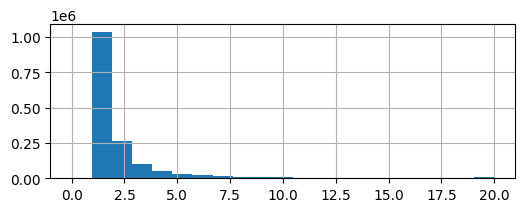

In [ ]:
train[target_col].hist(bins=train[target_col].nunique(), figsize=(6, 2))

In [ ]:
train[target_col].value_counts().sort_index()

item_cnt_month
0.0        3438
1.0     1037474
2.0      260432
3.0      101320
4.0       52368
5.0       31392
6.0       20390
7.0       13834
8.0       10272
9.0        7402
10.0       5910
11.0       4418
12.0       3651
13.0       2997
14.0       2402
15.0       2026
16.0       1716
17.0       1556
18.0       1272
19.0       1092
20.0      12231
Name: count, dtype: int64

In [ ]:
train_sales.pivot_table(
    values="item_cnt_day", columns=["shop_id"], index=["date_block_num", "item_id"]
)

shop_id                  0         1    2    3    4    5         6    7   8   \
date_block_num item_id                                                         
0              19       NaN       NaN  NaN  NaN  NaN  NaN       NaN  NaN NaN   
               27       NaN  1.000000  1.0  NaN  NaN  NaN       NaN  NaN NaN   
               28       NaN       NaN  NaN  NaN  NaN  NaN       NaN  NaN NaN   
               29       NaN  1.000000  NaN  NaN  NaN  NaN       NaN  NaN NaN   
               32       1.5  1.166667  NaN  1.0  1.0  NaN  1.333333  1.0 NaN   
...                     ...       ...  ...  ...  ...  ...       ...  ...  ..   
33             22162    NaN       NaN  NaN  NaN  NaN  NaN       NaN  NaN NaN   
               22163    NaN       NaN  NaN  NaN  NaN  1.0       NaN  NaN NaN   
               22164    NaN       NaN  NaN  1.0  NaN  1.0       NaN  NaN NaN   
               22166    NaN       NaN  NaN  NaN  NaN  NaN       NaN  NaN NaN   
               22167    NaN       NaN  NaN  NaN  NaN  NaN  1.000000  NaN NaN   

shop_id                 9   ...   50   51   52   53   54        55        56  \
date_block_num item_id      ...                                                
0              19      NaN  ...  NaN  NaN  NaN  NaN  NaN       NaN       NaN   
               27      NaN  ...  NaN  NaN  NaN  NaN  NaN       NaN       NaN   
               28      NaN  ...  NaN  NaN  NaN  NaN  NaN       NaN       NaN   
               29      NaN  ...  0.0  NaN  NaN  NaN  NaN       NaN       NaN   
               32      NaN  ...  NaN  1.0  1.0  1.0  1.4       NaN  1.111111   
...                     ..  ...  ...  ...  ...  ...  ...       ...       ...   
33             22162   NaN  ...  NaN  NaN  NaN  NaN  NaN       NaN       NaN   
               22163   NaN  ...  NaN  NaN  1.0  1.0  NaN       NaN       NaN   
               22164   NaN  ...  NaN  NaN  1.0  NaN  NaN       NaN       NaN   
               22166   NaN  ...  NaN  NaN  NaN  NaN  NaN  1.833333       NaN   
               22167   NaN  ...  1.0  NaN  NaN  NaN  NaN       NaN       NaN   

shop_id                  57   58   59  
date_block_num item_id                 
0              19       NaN  NaN  NaN  
               27       NaN  NaN  NaN  
               28       NaN  NaN  NaN  
               29       NaN  NaN  NaN  
               32       NaN  NaN  1.0  
...                     ...  ...  ...  
33             22162    NaN  1.0  NaN  
               22163    1.0  1.0  NaN  
               22164    NaN  NaN  NaN  
               22166    NaN  NaN  NaN  
               22167    NaN  NaN  NaN  

[233912 rows x 60 columns]

cartesian product trick (how to do this without `for` loop)

In [ ]:
cols = ["date_block_num", "shop_id", "item_id"]
train_sales_cart = []
for i in range(34):
    sales = train_sales_month[train_sales_month.date_block_num == i]
    train_sales_cart.append(
        np.array(
            list(product([i], sales.shop_id.unique(), sales.item_id.unique())),
            dtype="int16",
        )
    )

train_sales_cart = pd.DataFrame(np.vstack(train_sales_cart), columns=cols)
train_sales_cart["date_block_num"] = train_sales_cart["date_block_num"].astype(np.int8)
train_sales_cart["shop_id"] = train_sales_cart["shop_id"].astype(np.int8)
train_sales_cart["item_id"] = train_sales_cart["item_id"].astype(np.int16)
train_sales_cart = train_sales_cart.sort_values(cols)

train_sales_cart = pd.merge(train_sales_cart, train_sales_month, on=cols, how="left")
train_sales_cart["item_cnt_month"] = (
    train_sales_cart["item_cnt_month"].fillna(0).clip(0, 20).astype(np.float16)
)

In [ ]:
train_sales_cart["item_cnt_month"] = (
    train_sales_cart["item_cnt_month"].fillna(0).clip(0, 20).astype(np.float16)
)

In [ ]:
train_cart = train_sales_cart[train_sales_cart["date_block_num"] < 33].copy()
oos_cart = train_sales_cart[train_sales_cart["date_block_num"] == 33].copy()

<Axes: xlabel='item_cnt_month'>

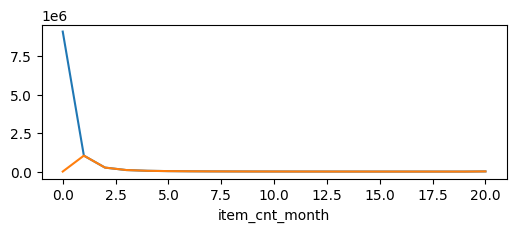

In [ ]:
train_cart[target_col].value_counts().sort_index().plot(figsize=(6, 2))
train[target_col].value_counts().sort_index().plot()

In [ ]:
train_featured = train_cart.merge(
    item_features[["item_id", "item_category_id"]], on="item_id", how="left"
).merge(shop_features[["shop_id", "shop_city"]], on="shop_id")
train_featured["mean_item_price"] = train_featured["item_id"].map(mean_item_price)


oos_featured = oos_cart.merge(
    item_features[["item_id", "item_category_id"]], on="item_id", how="left"
).merge(shop_features[["shop_id", "shop_city"]], on="shop_id")
oos_featured["mean_item_price"] = oos_featured["item_id"].map(mean_item_price)

In [ ]:
ctb = CatBoostRegressor(
    verbose=40,
    iterations=200,
    thread_count=6,
    allow_writing_files=False,
    cat_features=simple_cat_features,
)

In [ ]:
ctb.fit(train_featured[simple_features], train_featured[target_col])

Learning rate set to 0.5
0:	learn: 1.1802732	total: 1.08s	remaining: 3m 35s
40:	learn: 1.1189953	total: 30.8s	remaining: 1m 59s
80:	learn: 1.1113898	total: 1m 6s	remaining: 1m 37s
120:	learn: 1.1067322	total: 1m 42s	remaining: 1m 6s
160:	learn: 1.1033079	total: 2m 16s	remaining: 33.1s
199:	learn: 1.1004450	total: 2m 50s	remaining: 0us


In [ ]:
mean_squared_error(
    oos_featured[target_col], ctb.predict(oos_featured[simple_features])
) ** 0.5

1.1081334097428905

In [ ]:
submission = pd.DataFrame(
    {
        "ID": test_featured["ID"],
        "item_cnt_month": ctb.predict(test_featured[simple_features]),
    }
)
submission.to_csv("second_submission.csv", index=False)

![image.png](attachment:b589a75f-ae1d-47d0-b188-cfc6dff36b5a.png)

what to do:
* generate more cool features
* fix target encoding overfitting
* so on

## EDA: Yet another fraud detection (IEEE-CIS)

https://www.kaggle.com/competitions/ieee-fraud-detection

Can you detect fraud from customer transactions?

Пример хорошего EDA.

Сэмпл в данных - транзакция по карте, нужно предсказать, фрод это или нет. Метрика снова ROC AUC.

In [ ]:
train = pd.read_csv("../data/ieee-cis-antifraud/train_transaction.csv", nrows=5000)
train.head(15)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.500,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.000,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.000,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.000,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2987005,0,86510,49.000,W,5937,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.000,W,12308,360.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.500,W,12695,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.000,H,2803,100.0,150.0,visa,226.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2987009,0,86536,117.000,W,17399,111.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train["isFraud"].mean()

0.0218

Фичи:

In [ ]:
train_identity = pd.read_csv("../data/ieee-cis-antifraud/train_identity.csv")
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [ ]:
train = train.merge(train_identity, how='left', left_on='TransactionID',right_on='TransactionID')
train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.00000,4925.000000,5000.00000,4991.000000,4607.000000,4607.000000,...,929.000000,282.000000,929.000000,929.000000,33.000000,33.000000,32.000000,33.000000,33.000000,613.000000
mean,2.989500e+06,0.021800,139599.938800,145.453657,9737.22360,346.486701,152.33560,200.041875,293.029954,87.011721,...,183.486545,13.851064,357.878364,396.544672,397.939394,17.242424,12.375000,347.757576,148.696970,26.675367
std,1.443520e+03,0.146045,24886.671042,249.892398,4744.57947,158.139981,9.15116,38.570993,103.392233,0.324618,...,28.386762,1.473061,144.374854,150.939487,234.222776,8.385368,1.930235,104.727334,30.879286,3.777383
min,2.987000e+06,0.000000,86400.000000,1.896000,1033.00000,100.000000,100.00000,100.000000,110.000000,87.000000,...,102.000000,12.000000,100.000000,100.000000,228.000000,14.000000,11.000000,132.000000,100.000000,24.000000
25%,2.988250e+06,0.000000,129170.500000,47.950000,6459.00000,194.000000,150.00000,166.000000,204.000000,87.000000,...,166.000000,13.000000,254.000000,225.000000,252.000000,14.000000,11.000000,321.000000,121.000000,24.000000
50%,2.989500e+06,0.000000,146625.500000,78.950000,9335.00000,321.000000,150.00000,224.000000,299.000000,87.000000,...,166.000000,13.000000,352.000000,404.000000,252.000000,14.000000,11.000000,321.000000,147.000000,24.000000
75%,2.990749e+06,0.000000,158543.750000,150.000000,13481.00000,500.000000,150.00000,226.000000,330.000000,87.000000,...,225.000000,15.000000,427.000000,533.000000,657.000000,14.000000,15.000000,426.000000,184.000000,32.000000
max,2.991999e+06,1.000000,171642.000000,3247.910000,18390.00000,600.000000,191.00000,237.000000,536.000000,96.000000,...,225.000000,21.000000,669.000000,638.000000,849.000000,41.000000,15.000000,516.000000,216.000000,32.000000


Нам известна TransactionID, но не известен айдишник карты, а это было бы действительно полезно знать. Можно ли как-то его восстановить?

Можно было обратить внимание на колонку `D1` и заметить, что это похоже на количество дней с момента первой транзакции по карте.

Если нарисовать эту фичу против таймстемпа для какого-нибудь продукта (то есть подмножества строк), получится:

![image-2.png](attachment:image-2.png)

Судя по тому, что max фичи растет линейно со временем, это какая-то временная фича. Может, это какая-то хакатеристика транзакции или карты?

Давайте вычтем из нее день, посчитанный по TransactionDT:

![image-3.png](attachment:image-3.png)

Оранжевая горизонтальная линия намекает, что это могут быть транзакции с одной и той же фродовой карты. Это значит, что `D1` может быть количество дней с первой транзакции.

![image.png](attachment:image.png)

Как будто бы этого недостаточно, потому что 1к+ транзакций за 6 месяцев с одной карты это может быть многовато.

Если теперь взять конкретный `cardID_D1` и внимательней посмотреть на транзакции для одного продукта, близкие по времени записи с похожих девайсов и близких величин транзакций, можно найти, что `V307` это кумулятивная сумма транзакций, которая как раз и может помочь нам разделить карты внутри одного пользователя.

![image-4.png](attachment:image-4.png)

https://www.kaggle.com/code/tuttifrutti/creating-features-from-d-columns-guessing-userid

https://www.kaggle.com/code/tuttifrutti/isolating-a-cardid?scriptVersionId=21489147

Теперь можно это закодить и получить что-то похожее на айдишник карты. При этом не надо забывать и про более "общие" айдишники.

Как можно это использовать? Погенерировать фичи.

## Leaks

Лики бывают двух типов:
1. Те, которые допустили организаторы
2. Те, которые допустили вы

## Leak: Avito ad duplicates

https://www.kaggle.com/competitions/avito-duplicate-ads-detection

Ищем дубликаты объявлений

Из описания данных:

ItemPairs_train.csv – Pairs of ads that are duplicate and not duplicates on which to train.
- itemID_1 – identifier of the first ad.
- itemID_2 – identifier of the second ad.
- isDuplicate – target field. If itemID_1 and itemID_2 are duplicates or not (0 = not duplicate, 1 = duplicate).
- generationMethod – training data generation method. Different generation methods have different noise levels.
    - 1 = targets produced by humans when they consider only pair of ads.
    - 2 = targets produced by automatic algorithms.
    - 3 = targets produced by humans during analyses of all ads for the same owner.

In [ ]:
train_pairs = pd.read_csv("../data/avito-pairs/ItemPairs_train.csv")
test_pairs = pd.read_csv("../data/avito-pairs/ItemPairs_test.csv")

In [ ]:
train_pairs.head()

,itemID_1,itemID_2,isDuplicate,generationMethod
0,1,4112648,1,1
1,3,1991275,1,1
2,4,1223296,0,1
3,7,1058851,1,1
4,8,2161930,1,1


In [ ]:
train_pairs.shape

(2991396, 4)

In [ ]:
test_pairs.head()

,id,itemID_1,itemID_2
0,0,5,4670875
1,1,5,787210
2,2,6,1705280
3,3,11,3020777
4,4,23,5316130


In [ ]:
test_pairs.shape

(1044196, 3)

In [ ]:
train_pairs["isDuplicate"].mean()

0.4226384604378691

выглядит как будто набор пар совсем неслучаен, иначе таргет был бы гораздо ниже

![image.png](attachment:4db09564-4482-43d5-bc88-453d74295891.png)

we have also some features about ItemIDs, and even images from ads

whats wrong here?

In [ ]:
print("Items in train:", len(set(train_pairs["itemID_1"]).union(train_pairs["itemID_2"])))
print("Items in test:", len(set(test_pairs["itemID_1"]).union(test_pairs["itemID_2"])))

print("#Pairs/#Items for train:", len(train_pairs) / len(set(train_pairs["itemID_1"]).union(train_pairs["itemID_2"])))
print("#Pairs/#Items for test:", len(test_pairs) / len(set(test_pairs["itemID_1"]).union(test_pairs["itemID_2"])))

Items in train: 3344613
Items in test: 1315205
#Pairs/#Items for train: 0.8943922660110453
#Pairs/#Items for test: 0.7939416288715447


Сколько всего возможно пар объявлений для этого случая? Примерно `3e6 * 3e6 ~ 1e13`

Если взять рандомную пару объявлений, то ее вероятность быть дубликатом должна быть очень низка, но в трейне таргет около 0.42 - мы видели это выше

На основании чего отбирались пары? Если это неслучайный алгоритм, то из него можно вытащить информацию - что особенно интересно для теста.

Как это можно сделать?

![image.png](attachment:533a0df7-5975-4564-8a47-4df121a93c0a.png)

Можно собрать матрицу item-item из 0 и 1, где 1 - если в тесте была такая пара, 0 - если ее не было

Если теперь в качестве предикта использовать `cosine(vector_item1, vector_item2)`, то качество такого "прогноза" на ЛБ было уже 0.7-0.8 ROC AUC

Могла ли быть ситуация, в которой это бы не сработало?

Как еще можно было использовать эту особенность данных?

Разбор этого лика: https://youtu.be/tAoO1iA6nsk?t=1630

## Leak: Yandex Cup 24

Поиск каверов на песню

![image.png](attachment:d5d94483-3d95-4328-8f9f-a9f5b5ece84c.png)

Данные - CQT спектрограммы песен длиной 60с

![image.png](attachment:e52aabba-0d15-44be-aaea-65efbf1d8f85.png)

Количество клик (груп каверов) в трейне около 41к, количество песен - около 310к

В тесте количество клик (груп каверов) около 7к, количество песен - около 55к

Где тут мог быть лик?

Если посмотреть на матрицу попарных косинусных расстояний между песнями в тесте, можно было увидеть:

![image.png](attachment:c33f2cb9-f13c-4798-b550-bc40e869b05b.png)

Тестовые данные не были зашафлены, и клики (группы каверов) располагались друг за другом

Как это можно было использовать?

## Leak: Truly Native

https://www.kaggle.com/competitions/dato-native/discussion/16485

Predict which web pages served by StumbleUpon are sponsored

![image-2.png](attachment:image-2.png)

Где тут мог бы быть лик?

...

> the data provided in this dataset had a hidden "feature" which is in date stamp of the files

![image.png](attachment:image.png)

<Axes: xlabel='number'>

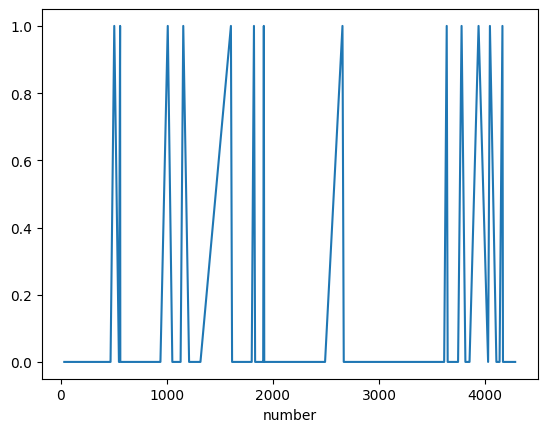

In [ ]:
train = pd.read_csv("../data/truly-native/train.csv")
train["number"] = train.file.map(lambda x: int(x.split('_')[0]))
train.sort_values(["number"]).set_index("number").head(100).sponsored.plot()

In [ ]:
import os
import pandas as pd
from datetime import datetime

# Define the folder path
folder_path = '/Users/aguschin/Downloads/4'

# Get all files in the folder with their modification dates
if os.path.exists(folder_path):
    file_data = []
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path):  # Ensure it's a file
            mod_time = os.path.getmtime(file_path)  # Modification time in seconds since epoch
            mod_time_readable = datetime.fromtimestamp(mod_time).strftime('%Y-%m-%d %H:%M:%S')  # Convert to readable format
            file_data.append({'file': file_name, 'modification_date': mod_time_readable})

    mod_dates = pd.DataFrame(file_data)
    mod_dates.to_csv("../data/truly-native/modification_dates.csv", index=False)

In [ ]:
mod_dates = pd.read_csv("../data/truly-native/modification_dates.csv")
mod_dates

,file,modification_date
0,3162778_raw_html.txt,2015-07-15 03:33:13
1,3338896_raw_html.txt,2015-07-15 04:40:40
2,3140338_raw_html.txt,2015-07-15 03:09:35
3,3239176_raw_html.txt,2015-07-15 03:25:40
4,3569584_raw_html.txt,2015-07-15 03:28:18
...,...,...
67531,1206004_raw_html.txt,2015-07-15 04:20:31
67532,123268_raw_html.txt,2015-07-15 04:03:11
67533,1761868_raw_html.txt,2015-07-15 03:16:17
67534,800956_raw_html.txt,2015-07-15 03:02:09


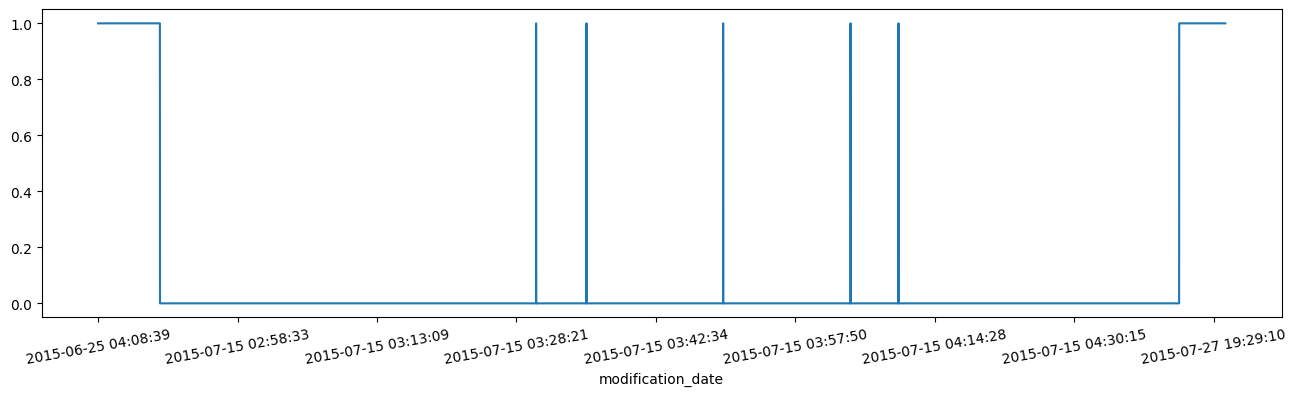

In [ ]:
dfm = train.merge(mod_dates, how='left', on=["file"])
dfm.loc[dfm.modification_date.notnull()].sort_values('modification_date').set_index('modification_date').sponsored.plot(figsize=(16, 4))
plt.xticks(rotation=10);

## Leak: LMSYS

https://www.kaggle.com/competitions/lmsys-chatbot-arena/overview

LMSYS - Chatbot Arena Human Preference Predictions

Predicting Human Preferences in the Wild

![image.png](attachment:image.png)

In [ ]:
train = pd.read_csv("../data/lmsys/train.csv", nrows=500)
test = pd.read_csv("../data/lmsys/test.csv", nrows=500)

In [ ]:
train.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0


In [ ]:
test.head()

,id,prompt,response_a,response_b
0,136060,"[""I have three oranges today, I ate an orange ...","[""You have two oranges today.""]","[""You still have three oranges. Eating an oran..."
1,211333,"[""You are a mediator in a heated political deb...","[""Thank you for sharing the details of the sit...","[""Mr Reddy and Ms Blue both have valid points ..."
2,1233961,"[""How to initialize the classification head wh...","[""When you want to initialize the classificati...","[""To initialize the classification head when p..."


В какой-то момент организаторы опубликовали ноутбук https://colab.research.google.com/drive/1KdwokPjirkTmpO_P1WByFNFiqxWQquwH

> In this notebook, we present data analysis on Chatbot Arena data collected from https://arena.lmsys.org.
>
> We explain different Elo calculation methods (online Elo and Bradley-Terry model) for model ranking.
>
> To view the latest leaderboard, see https://huggingface.co/spaces/lmsys/chatbot-arena-leaderboard.

![image-2.png](attachment:image-2.png)
![image-3.png](attachment:image-3.png)

Вскоре после этого был найден лик:
https://www.kaggle.com/competitions/lmsys-chatbot-arena/discussion/524079

Возможно, что это и есть тестовый набор данных для соревнования. К сожалению промтов нет (а в соревновании нам даны промты и ответы обоих моделей). Можно ли обойтись без них?

Можно ли как-то использовать `sum_user_tokens` в `conv_metadata`?

Ключ к решению - найти правильный токенайзер. Организаторы LMSYS использовали `tiktoken` в других ноутбуках, может здесь используется он же?

Человек, который нашел лик поделился с нами ноутбуком, где использовал лик, и сообщил:

> In 'leaked' data was the only dialogue with `'sum_user_tokens' == 19`. By iterating `tiktoken` version, we can find proper version where this dialogue has len 19

Даже если бы этого факта не было известно, что тут можно было бы сделать?

In [ ]:
# get leaked data

with open("/kaggle/input/leak-find/battles.json", "r") as file:
    battles = pd.read_json(file).sort_values(ascending=True, by=["tstamp"])

# get needed tiktoken
import tiktoken

encoding = tiktoken.get_encoding("cl100k_base")

# use the leak
result_df2 = pd.DataFrame(
    columns=["id", "winner_model_a", "winner_model_b", "winner_tie"]
)

for i in range(len(multiturn_df)):
    prompt = multiturn_df.iloc[i]["len_prompt"]
    response_a = multiturn_df.iloc[i]["len_response_a"]
    response_b = multiturn_df.iloc[i]["len_response_b"]

    matched_row = unique_rows[
        (unique_rows["len_prompt"] == prompt)
        & (unique_rows["len_response_a"] == response_a)
        & (unique_rows["len_response_b"] == response_b)
    ]

    matched_row2 = unique_rows[
        (unique_rows["len_prompt"] == prompt)
        & (unique_rows["len_response_a"] == response_b)
        & (unique_rows["len_response_b"] == response_a)
    ]

    if len(matched_row) > 0 & len(matched_row2) == 0:
        winner = matched_row["winner"].iloc[0]
        winner_model_a = 0.95 if winner == "model_a" else 0.025
        winner_model_b = 0.95 if winner == "model_b" else 0.025
        winner_tie = 0.95 if winner == "tie" or winner == "tie (bothbad)" else 0.025

        new_row = pd.DataFrame(
            {
                "id": [multiturn_df.iloc[i]["id"]],
                "winner_model_a": [winner_model_a],
                "winner_model_b": [winner_model_b],
                "winner_tie": [winner_tie],
            }
        )

    if len(matched_row2) > 0 & len(matched_row) == 0:
        winner = matched_row2["winner"].iloc[0]
        winner_model_a = 0.95 if winner == "model_a" else 0.025
        winner_model_b = 0.95 if winner == "model_b" else 0.025
        winner_tie = 0.95 if winner == "tie" or winner == "tie (bothbad)" else 0.025

        new_row = pd.DataFrame(
            {
                "id": [multiturn_df.iloc[i]["id"]],
                "winner_model_a": [winner_model_b],
                "winner_model_b": [winner_model_a],
                "winner_tie": [winner_tie],
            }
        )

        result_df2 = pd.concat([result_df2, new_row], ignore_index=True)

^ это был сабмит на первое место на ЛБ

## Possible leak: GSM 8k

Иногда тестовые данные ликаются в обучающие датасеты для LLM.

Например, GSM 8k бенчмарк (Grade School Math https://github.com/openai/grade-school-math/tree/master)

Задача LLM-ки решать математические задачи и выдавать точный ответ (обычно одно число).

Примеры из трейна:

In [ ]:
{
    "question": "Tim rides his bike back and forth to work for each of his 5 workdays.  His work is 20 miles away.  He also goes for a weekend bike ride of 200 miles.    If he can bike at 25 mph how much time does he spend biking a week?",
    "answer": "He bikes 20*2=<<20*2=40>>40 miles each day for work\nSo he bikes 40*5=<<40*5=200>>200 miles for work\nThat means he bikes a total of 200+200=<<200+200=400>>400 miles for work\nSo he bikes a total of 400/25=<<400/25=16>>16 hours\n#### 16",
}
{
    "question": "Bella bought stamps at the post office. Some of the stamps had a snowflake design, some had a truck design, and some had a rose design. Bella bought 11 snowflake stamps. She bought 9 more truck stamps than snowflake stamps, and 13 fewer rose stamps than truck stamps. How many stamps did Bella buy in all?",
    "answer": "The number of truck stamps is 11 + 9 = <<11+9=20>>20.\nThe number of rose stamps is 20 \u2212 13 = <<20-13=7>>7.\nBella bought 11 + 20 + 7 = <<11+20+7=38>>38 stamps in all.\n#### 38",
}
{
    "question": "Each bird eats 12 beetles per day, each snake eats 3 birds per day, and each jaguar eats 5 snakes per day. If there are 6 jaguars in a forest, how many beetles are eaten each day?",
    "answer": "First find the total number of snakes eaten: 5 snakes/jaguar * 6 jaguars = <<5*6=30>>30 snakes\nThen find the total number of birds eaten per day: 30 snakes * 3 birds/snake = <<30*3=90>>90 snakes\nThen multiply the number of snakes by the number of beetles per snake to find the total number of beetles eaten per day: 90 snakes * 12 beetles/snake = <<90*12=1080>>1080 beetles\n#### 1080",
}
{
    "question": "Samantha\u2019s last name has three fewer letters than Bobbie\u2019s last name. If Bobbie took two letters off her last name, she would have a last name twice the length of Jamie\u2019s. Jamie\u2019s full name is Jamie Grey. How many letters are in Samantha\u2019s last name?",
    "answer": "There are 4 letters in Jamie\u2019s last name, so Bobbie\u2019s name is 4*2 +2 = <<4*2+2=10>>10 letters long.\nSamantha\u2019s last name is 3 letters shorter than Bobbie\u2019s, so there are 10 - 3 = <<10-3=7>>7 letters in Samantha\u2019s last name.\n#### 7",
}

Правильный ответ находится после `####`. Если хочется забенчмаркать LLM на таком датасете, можно вначале дать несколько примеров в промпте (Few-Shot prompting).

Однако, некоторые языковые модели уже могут иметь это как часть своей обучающей выборки, например llama 3.1. Это можно заметить если модель выдает ответ в правильном формате в zero-shot (https://github.com/EleutherAI/lm-evaluation-harness/blob/main/examples/lm-eval-overview.ipynb):

In [ ]:
{
    "doc_id": 123,
    "doc": {
        "question": "Rosie can run 10 miles per hour for 3 hours. After that, she runs 5 miles per hour. How many miles can she run in 7 hours?",
        "answer": "For the first 3 hours, Rosie runs 10 miles per hour, so she runs 10*3=<<10*3=30>>30 miles.\nHowever, she still has 7-3=<<7-3=4>>4 hours left to room.\nFor the next 4 hours, she runs 5 miles per hour, so she runs 5*4=<<5*4=20>>20 miles.\nIn total she runs 30+20=<<30+20=50>>50 miles.\n#### 50",
    },
    "target": "For the first 3 hours, Rosie runs 10 miles per hour, so she runs 10*3=<<10*3=30>>30 miles.\nHowever, she still has 7-3=<<7-3=4>>4 hours left to room.\nFor the next 4 hours, she runs 5 miles per hour, so she runs 5*4=<<5*4=20>>20 miles.\nIn total she runs 30+20=<<30+20=50>>50 miles.\n#### 50",
    "arguments": {
        "gen_args_0": {
            "arg_0": "<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\nQuestion: Rosie can run 10 miles per hour for 3 hours. After that, she runs 5 miles per hour. How many miles can she run in 7 hours?\nAnswer:<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n",
            "arg_1": {
                "until": ["Question:", "</s>", "<|im_end|>"],
                "do_sample": False,
                "temperature": 0.0,
            },
        }
    },
    "resps": [
        [
            "Rosie can run 10 miles per hour for 3 hours. So she can run 10 * 3 = 30 miles. After that, she runs 5 miles per hour. So in 7 hours, she can run 30 + 5 * 4 = 30 + 20 = 50 miles.\n#### 50"
        ]
    ],
    "filtered_resps": ["50"],
    "doc_hash": "3878b31a0e4251e376dd1a691a757ad2013126910f529e39ad655370044ad966",
    "prompt_hash": "3579168e57e339465de0625a3358623a83578d0ac487934756f2b6bb3e576243",
    "target_hash": "de3d896a77bfc7451960b811f998ee11f17de586da33d8258d5a5ecc207daf56",
    "exact_match": 1.0,
};

Лик может заключаться не только в текстах, но и в картинках или метаданных файлов (и тд), которые видела мультимодальная LLM-ка.

## Leak: Utashuda leak in pictures metadata

https://cups.online/ru/contests/hackathon_ai_arrow

Задача - посчитать количество чаек на картинках

![image.png](attachment:3d07294e-8a0f-46aa-9525-4571f0e7f623.png)

Какой здесь мог бы быть лик?

Картинки в трейне и тесте:

![image.png](attachment:3aaf2382-31fa-4262-94fd-e2af35e44ced.png)

Ошибка в случайном сплите данных между трейном и тестом.

Если две картинки были сделаны в близкое время, количество чаек на них было похожим.

Как это использовать? Искать ближайших соседей.

## Leak: TGS Salt Identification Challenge

https://www.kaggle.com/competitions/tgs-salt-identification-challenge

Segment salt deposits beneath the Earth's surface

Фотографии из трейна + маски с залежами соли (картинки из теста не имели масок - их мы и предказываем):

![image.png](attachment:23357777-da8c-4e6d-8b3d-2e1edf70a406.png)

Как такие картинки можно было бы получить? Как организаторы могли их сделать?

Обрезая одну большую картинку на множество маленьких.

Участники решили собрать пазл обратно:

![image.png](attachment:bec828c0-7805-40ee-a0b6-c8853b5b8704.png)

Что такое дырки на этой картинке?

...

Это тестовые данные.

Как это можно было использовать?

## Leak: TalkingData AdTracking Fraud Detection Challenge

https://www.kaggle.com/competitions/talkingdata-adtracking-fraud-detection/overview

Can you detect fraudulent click traffic for mobile app ads?

In [ ]:
train_sample = pd.read_csv("../data/talking-data-adfraud/train_sample.csv")

In [ ]:
train_sample.head(15)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0
5,93663,3,1,17,115,2017-11-09 01:22:13,NaN,0
6,17059,1,1,17,135,2017-11-09 01:17:58,NaN,0
7,121505,9,1,25,442,2017-11-07 10:01:53,NaN,0
8,192967,2,2,22,364,2017-11-08 09:35:17,NaN,0
9,143636,3,1,19,135,2017-11-08 12:35:26,NaN,0


In [ ]:
train_sample["is_attributed"].mean()

0.00227

Какой здесь возможен лик?

Давайте посмотрим на колонку `click_time` и обратим внимание, что время у нас в секундах. Есть ли дубликаты по времени в `train_sample`?

In [ ]:
train_sample["click_time"].value_counts()

click_time
2017-11-08 12:01:02    7
2017-11-07 05:00:11    6
2017-11-09 14:46:23    6
2017-11-07 04:36:16    6
2017-11-08 13:32:05    6
                      ..
2017-11-07 08:31:55    1
2017-11-08 23:35:15    1
2017-11-08 10:01:33    1
2017-11-09 11:01:52    1
2017-11-09 13:25:41    1
Name: count, Length: 80350, dtype: int64

In [ ]:
for i in train_sample["click_time"].value_counts().index:
    subs = train_sample[train_sample["click_time"] == i]
    if (subs["is_attributed"] == 1).any():
        break
subs

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
4318,42956,3,1,13,280,2017-11-07 00:38:43,NaN,0
48670,139024,12,1,13,259,2017-11-07 00:38:43,NaN,0
58852,22957,3,1,13,173,2017-11-07 00:38:43,NaN,0
69193,85364,35,1,13,21,2017-11-07 00:38:43,2017-11-07 09:07:51,1


Данные отсортированы по `click_time` и затем по `target`

Как это можно использовать?

## Итоги

Давайте попробуем обобщить, в каких местах нам стоит искать лики.

1. Если в соревновании есть файлы, то в метадате этих файлов - их названиях, датах создания и модификации, авторах и тд
2. Если в соревновании есть время, проверить, по времени ли данные разбиты на трейн и тест
3. Если в соревновании нет времени, попробовать его поискать - вдруг оно где-нибудь отыщется:)
4. Если в соревновании есть более крупные айдишники (например, айдишник юзера когда сэмпл - это транзакция) - посмотреть не пересекаются ли они между трейном и тестом
5. Посмотреть внимательно, как упорядочены данные в трейне и тесте.
6. Если в данных есть пары сэмплов, посмотреть на них внимательно
7. При обработке признаков не откидывайте доп.информацию, а лучше создавайте дополнительную фичу.